In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import itertools
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
# Configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import os
import shutil
from PIL import Image

# Define paths
input_dir = '/kaggle/input/utkface-new/UTKFace'  
young_dir = '/kaggle/working/Input/young'
old_dir = '/kaggle/working/Input/old'

# Create directories if they don't exist
os.makedirs(young_dir, exist_ok=True)
os.makedirs(old_dir, exist_ok=True)

# Age brackets
young_min_age, young_max_age = 18, 30
old_min_age, old_max_age = 50, 80

# Function to get age from filename
def get_age_from_filename(filename):
    return int(filename.split('_')[0])

# Process images
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):
        age = get_age_from_filename(filename)
        
        if young_min_age <= age <= young_max_age:
            shutil.copy(os.path.join(input_dir, filename), os.path.join(young_dir, filename))
        elif old_min_age <= age <= old_max_age:
            shutil.copy(os.path.join(input_dir, filename), os.path.join(old_dir, filename))

print("Images have been successfully divided and saved.")


Images have been successfully divided and saved.


In [3]:


class CustomImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = 0 if 'young' in self.root_dir else 1  # Assign labels based on directory name
        
        return image, label
    

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

young_dataset = CustomImageFolderDataset('/kaggle/working/Input/young', transform=transform)
old_dataset = CustomImageFolderDataset('/kaggle/working/Input/old', transform=transform)

# Create DataLoaders
batch_size = 16
young_loader = DataLoader(young_dataset, batch_size=batch_size, shuffle=True)
old_loader = DataLoader(old_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
# Generator model
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, padding=0),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, padding=0),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out       


In [6]:

class GeneratorResNet(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [7]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, stride=1, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(512, 1, 4, stride=1, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [8]:

# Initialize models
input_nc = 3
output_nc = 3
netG_A2B = GeneratorResNet(input_nc, output_nc).to(device)
netG_B2A = GeneratorResNet(input_nc, output_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(input_nc).to(device)

# Initialize weights
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
print(device)

cuda


In [9]:
# Adversarial ground truths
def get_adversarial_targets(batch_size, device):
    return Variable(torch.Tensor(np.ones((batch_size, 1, 1, 1))).to(device)), Variable(torch.Tensor(np.zeros((batch_size, 1, 1, 1))).to(device))

## Training
### Uncomment the below cell to train

In [10]:
# num_epochs = 10
# # Training Loop
# for epoch in range(num_epochs):
#     for i, (young_img, old_img) in enumerate(zip(young_loader, old_loader)):
#         # Set model input
#         real_A = Variable(young_img[0].to(device))
#         real_B = Variable(old_img[0].to(device))

#         # Adversarial ground truths
#         valid_A, invalid_A = get_adversarial_targets(real_A.size(0), device)
#         valid_B, invalid_B = get_adversarial_targets(real_B.size(0), device)
        
#         #  Train Generators
#         optimizer_G.zero_grad()

#         # Identity loss
#         loss_id_A = criterion_identity(netG_B2A(real_A), real_A)
#         loss_id_B = criterion_identity(netG_A2B(real_B), real_B)

#         loss_identity = (loss_id_A + loss_id_B) / 2

#         # GAN loss
#         fake_B = netG_A2B(real_A)
#         loss_GAN_A2B = criterion_GAN(netD_B(fake_B), valid_B)
#         fake_A = netG_B2A(real_B)
#         loss_GAN_B2A = criterion_GAN(netD_A(fake_A), valid_A)

#         loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

#         # Cycle loss
#         recovered_A = netG_B2A(fake_B)
#         loss_cycle_A = criterion_cycle(recovered_A, real_A)
#         recovered_B = netG_A2B(fake_A)
#         loss_cycle_B = criterion_cycle(recovered_B, real_B)

#         loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

#         # Total loss
#         loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

#         loss_G.backward()
#         optimizer_G.step()

#         #  Train Discriminator A
#         optimizer_D_A.zero_grad()

#         # Real loss
#         loss_real = criterion_GAN(netD_A(real_A), valid_A)
#         # Fake loss (on batch of previously generated samples)
#         loss_fake = criterion_GAN(netD_A(fake_A.detach()), invalid_A)
#         # Total loss
#         loss_D_A = (loss_real + loss_fake) / 2

#         loss_D_A.backward()
#         optimizer_D_A.step()

        
#         #  Train Discriminator B
#         optimizer_D_B.zero_grad()

#         # Real loss
#         loss_real = criterion_GAN(netD_B(real_B), valid_B)
#         # Fake loss (on batch of previously generated samples)
#         loss_fake = criterion_GAN(netD_B(fake_B.detach()), invalid_B)
#         # Total loss
#         loss_D_B = (loss_real + loss_fake) / 2

#         loss_D_B.backward()
#         optimizer_D_B.step()

#         #  Log Progress
#         print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(young_loader)}] "
#               f"[D loss: {loss_D_A.item() + loss_D_B.item()}] "
#               f"[G loss: {loss_G.item()}, adv: {loss_GAN.item()}, cycle: {loss_cycle.item()}, identity: {loss_identity.item()}]")


In [ ]:
torch.save(netG_A2B.state_dict(), '/kaggle/working/netG_A2B.pth')
torch.save(netG_B2A.state_dict(), '/kaggle/working/netG_B2A.pth')
torch.save(netD_A.state_dict(), '/kaggle/working/netD_A.pth')
torch.save(netD_B.state_dict(), '/kaggle/working/netD_B.pth')

## Loading Weights

In [11]:
import torch

# Load weights 
netG_A2B.load_state_dict(torch.load('/kaggle/input/weights-final/netG_A2B_59.pth'))
netG_B2A.load_state_dict(torch.load('/kaggle/input/weights-final/netG_B2A_59.pth'))
netD_A.load_state_dict(torch.load('/kaggle/input/weights-final/netD_A_59.pth'))
netD_B.load_state_dict(torch.load('/kaggle/input/weights-final/netD_B59.pth'))


<All keys matched successfully>

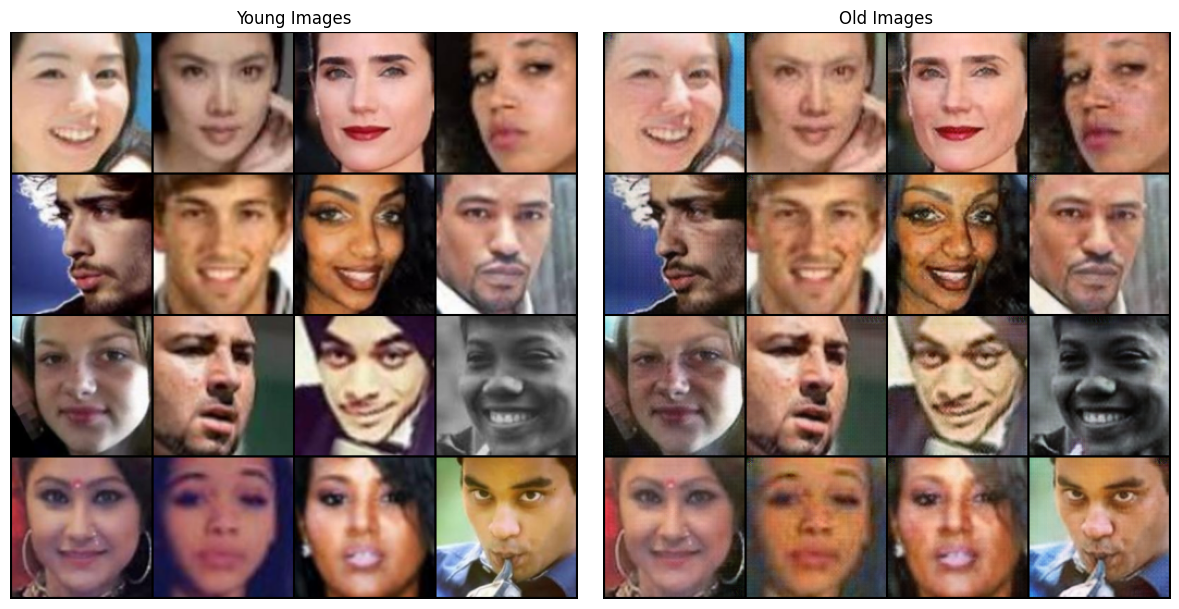

In [21]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
#     plt.show()

for images, labels in young_loader:
    input_grid = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)
    output_images = netG_A2B(images.to(device))
    output_grid = torchvision.utils.make_grid(output_images.cpu(), nrow=4, padding=2, normalize=True)

    # Display input and output images side by side
    plt.figure(figsize=(12, 6))

    # Display input images
    plt.subplot(1, 2, 1)
    imshow(input_grid)
    plt.title('Young Images')

    # Display output images
    plt.subplot(1, 2, 2)
    imshow(output_grid)
    plt.title('Old Images')

    plt.tight_layout()
    plt.show()
    break

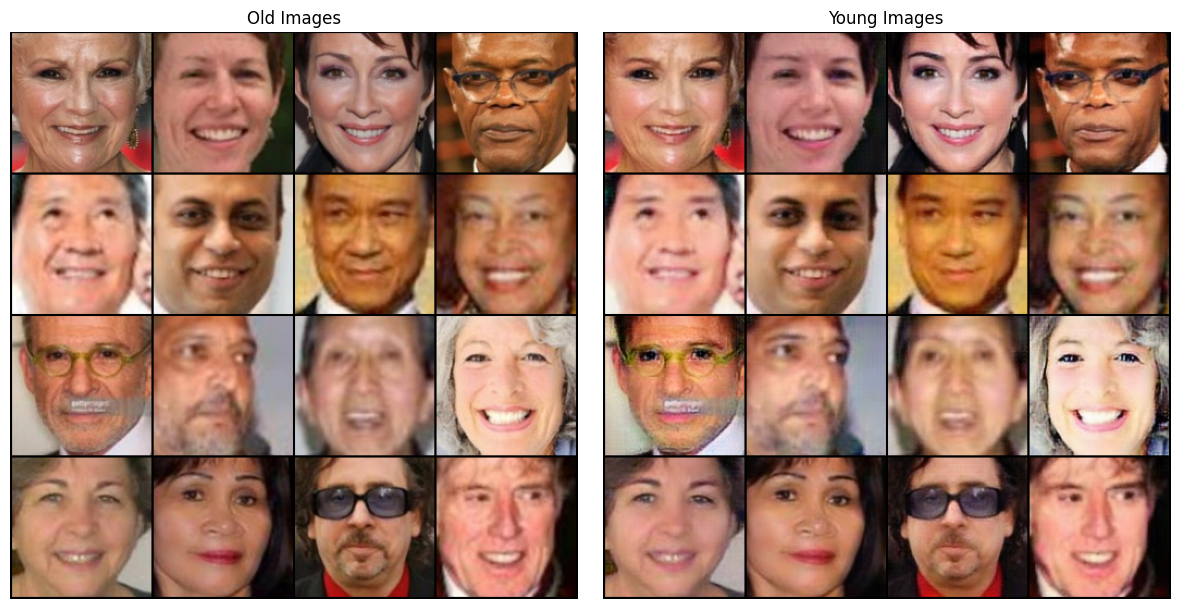

In [26]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
#     plt.show()

for images, labels in old_loader:
    input_grid = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)
    output_images = netG_B2A(images.to(device)) 
    output_grid = torchvision.utils.make_grid(output_images.cpu(), nrow=4, padding=2, normalize=True)

    # Display input and output images side by side
    plt.figure(figsize=(12, 6))

    # Display input images
    plt.subplot(1, 2, 1)
    imshow(input_grid)
    plt.title('Old Images')

    # Display output images
    plt.subplot(1, 2, 2)
    imshow(output_grid)
    plt.title('Young Images')

    plt.tight_layout()
    plt.show()
    break

### Testing on Image not in dataset 

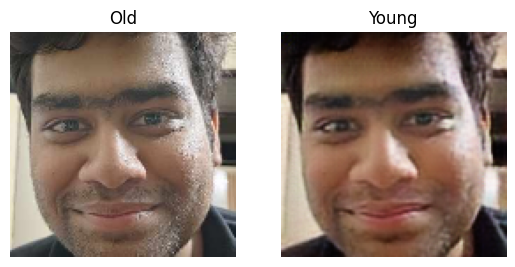

In [41]:
img = cv2.imread('/kaggle/input/testimage/Image.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128,128))

# Convert image to tensor
to_tensor = transforms.ToTensor()
tensor = to_tensor(img).to(device)

# Get the transformed image
old = netG_B2A(tensor)

# Plot the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Old")
ax[0].axis('off')  

ax[1].imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
ax[1].set_title("Young")
ax[1].axis('off') 

plt.show()